In [1]:
import os, json, sys, time, random
import numpy as np
import torch
from  easydict import EasyDict
from math import floor
from easydict import EasyDict

from steves_utils.vanilla_train_eval_test_jig import  Vanilla_Train_Eval_Test_Jig

from steves_utils.torch_utils import get_dataset_metrics, independent_accuracy_assesment
from steves_models.configurable_vanilla import Configurable_Vanilla
from steves_utils.torch_sequential_builder import build_sequential
from steves_utils.lazy_map import Lazy_Map
from steves_utils.sequence_aggregator import Sequence_Aggregator

from steves_utils.stratified_dataset.traditional_accessor import Traditional_Accessor_Factory

from steves_utils.cnn_do_report import (
    get_loss_curve,
    get_results_table,
    get_parameters_table,
    get_domain_accuracies,
)

from steves_utils.torch_utils import (
    confusion_by_domain_over_dataloader,
    independent_accuracy_assesment
)

from steves_utils.utils_v2 import (
    per_domain_accuracy_from_confusion,
    get_datasets_base_path
)

# from steves_utils.ptn_do_report import TBD

In [2]:
required_parameters = {
    "experiment_name",
    "lr",
    "device",
    "dataset_seed",
    "seed",
    "labels",
    "domains_target",
    "domains_source",
    "num_examples_per_domain_per_label_source",
    "num_examples_per_domain_per_label_target",
    "batch_size",
    "n_epoch",
    "patience",
    "criteria_for_best",
    "normalize_source",
    "normalize_target",
    "x_net",
    "NUM_LOGS_PER_EPOCH",
    "BEST_MODEL_PATH",
    "pickle_name_source",
    "pickle_name_target",
    "torch_default_dtype",
}

In [3]:
from steves_utils.ORACLE.utils_v2 import (
    ALL_SERIAL_NUMBERS,
    ALL_DISTANCES_FEET_NARROWED,
)

standalone_parameters = {}
standalone_parameters["experiment_name"] = "MANUAL CORES CNN"
standalone_parameters["lr"] = 0.0001
standalone_parameters["device"] = "cuda"

standalone_parameters["dataset_seed"] = 1337
standalone_parameters["seed"] = 1337
standalone_parameters["labels"] = ALL_SERIAL_NUMBERS

standalone_parameters["domains_source"] = [8,32,50]
standalone_parameters["domains_target"] = [14,20,26,38,44,]

standalone_parameters["num_examples_per_domain_per_label_source"]=-1
standalone_parameters["num_examples_per_domain_per_label_target"]=-1

standalone_parameters["pickle_name_source"] = "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl"
standalone_parameters["pickle_name_target"] = "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"

standalone_parameters["torch_default_dtype"] = "torch.float32" 

standalone_parameters["batch_size"]=128

standalone_parameters["n_epoch"] = 3

standalone_parameters["patience"] = 10

standalone_parameters["criteria_for_best"] = "target_accuracy"
standalone_parameters["normalize_source"] = False
standalone_parameters["normalize_target"] = False

standalone_parameters["x_net"] =     [
    {"class": "nnReshape", "kargs": {"shape":[-1, 1, 2, 256]}},
    {"class": "Conv2d", "kargs": { "in_channels":1, "out_channels":256, "kernel_size":(1,7), "bias":False, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":256}},

    {"class": "Conv2d", "kargs": { "in_channels":256, "out_channels":80, "kernel_size":(2,7), "bias":True, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":80}},
    {"class": "Flatten", "kargs": {}},

    {"class": "Linear", "kargs": {"in_features": 80*256, "out_features": 256}}, # 80 units per IQ pair
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm1d", "kargs": {"num_features":256}},

    {"class": "Linear", "kargs": {"in_features": 256, "out_features": len(standalone_parameters["labels"])}},
]

standalone_parameters["NUM_LOGS_PER_EPOCH"] = 10
standalone_parameters["BEST_MODEL_PATH"] = "./best_model.pth"

In [4]:
# Parameters
parameters = {
    "experiment_name": "cnn_3:oracle.run1-oracle.run2",
    "domains_source": [8, 32, 50, 14, 20, 26, 38, 44],
    "domains_target": [8, 32, 50, 14, 20, 26, 38, 44],
    "labels": [
        "3123D52",
        "3123D65",
        "3123D79",
        "3123D80",
        "3123D54",
        "3123D70",
        "3123D7B",
        "3123D89",
        "3123D58",
        "3123D76",
        "3123D7D",
        "3123EFE",
        "3123D64",
        "3123D78",
        "3123D7E",
        "3124E4A",
    ],
    "pickle_name_source": "oracle.Run1_10kExamples_stratified_ds.2022A.pkl",
    "pickle_name_target": "oracle.Run2_10kExamples_stratified_ds.2022A.pkl",
    "device": "cuda",
    "lr": 0.0001,
    "batch_size": 128,
    "normalize_source": False,
    "normalize_target": False,
    "num_examples_per_domain_per_label_source": -1,
    "num_examples_per_domain_per_label_target": -1,
    "torch_default_dtype": "torch.float32",
    "n_epoch": 50,
    "patience": 3,
    "criteria_for_best": "target_accuracy",
    "x_net": [
        {"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 1,
                "out_channels": 256,
                "kernel_size": [1, 7],
                "bias": False,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 256}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 256,
                "out_channels": 80,
                "kernel_size": [2, 7],
                "bias": True,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 80}},
        {"class": "Flatten", "kargs": {}},
        {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}},
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm1d", "kargs": {"num_features": 256}},
        {"class": "Linear", "kargs": {"in_features": 256, "out_features": 16}},
    ],
    "NUM_LOGS_PER_EPOCH": 10,
    "BEST_MODEL_PATH": "./best_model.pth",
    "dataset_seed": 1337,
    "seed": 1337,
}


In [5]:
# Set this to True if you want to run this template directly
STANDALONE = False
if STANDALONE:
    print("parameters not injected, running with standalone_parameters")
    parameters = standalone_parameters

if not 'parameters' in locals() and not 'parameters' in globals():
    raise Exception("Parameter injection failed")

#Use an easy dict for all the parameters
p = EasyDict(parameters)

supplied_keys = set(p.keys())

if  supplied_keys != required_parameters:
    print("Parameters are incorrect")
    if len(supplied_keys - required_parameters)>0: print("Shouldn't have:", str(supplied_keys - required_parameters))
    if len(required_parameters - supplied_keys)>0: print("Need to have:", str(required_parameters - supplied_keys))
    raise RuntimeError("Parameters are incorrect")



In [6]:
###################################
# Set the RNGs and make it all deterministic
###################################
np.random.seed(p.seed)
random.seed(p.seed)
torch.manual_seed(p.seed)

torch.use_deterministic_algorithms(True) 

In [7]:
torch.set_default_dtype(eval(p.torch_default_dtype))

In [8]:
###################################
# Build the network(s)
# Note: It's critical to do this AFTER setting the RNG
###################################
x_net = build_sequential(p.x_net)

In [9]:
start_time_secs = time.time()

In [10]:
def wrap_in_dataloader(p, ds):
    return torch.utils.data.DataLoader(
        ds,
        batch_size=p.batch_size,
        shuffle=True,
        num_workers=1,
        persistent_workers=True,
        prefetch_factor=50,
        pin_memory=True
    )

taf_source = Traditional_Accessor_Factory(
    labels=p.labels,
    domains=p.domains_source,
    num_examples_per_domain_per_label=p.num_examples_per_domain_per_label_source,
    pickle_path=os.path.join(get_datasets_base_path(), p.pickle_name_source),
    seed=p.dataset_seed
)
train_original_source, val_original_source, test_original_source = \
    taf_source.get_train(), taf_source.get_val(), taf_source.get_test()


taf_target = Traditional_Accessor_Factory(
    labels=p.labels,
    domains=p.domains_target,
    num_examples_per_domain_per_label=p.num_examples_per_domain_per_label_source,
    pickle_path=os.path.join(get_datasets_base_path(), p.pickle_name_target),
    seed=p.dataset_seed
)
train_original_target, val_original_target, test_original_target = \
    taf_target.get_train(), taf_target.get_val(), taf_target.get_test()


# For CNN We only use X and Y. And we only train on the source.
# Properly form the data using a transform lambda and Lazy_Map. Finally wrap them in a dataloader

transform_lambda = lambda ex: ex[:2] # Strip the tuple to just (x,y)


train_processed_source = wrap_in_dataloader(
    p,
    Lazy_Map(train_original_source, transform_lambda)
)
val_processed_source = wrap_in_dataloader(
    p,
    Lazy_Map(val_original_source, transform_lambda)
)
test_processed_source = wrap_in_dataloader(
    p,
    Lazy_Map(test_original_source, transform_lambda)
)

train_processed_target = wrap_in_dataloader(
    p,
    Lazy_Map(train_original_target, transform_lambda)
)
val_processed_target = wrap_in_dataloader(
    p,
    Lazy_Map(val_original_target, transform_lambda)
)
test_processed_target  = wrap_in_dataloader(
    p,
    Lazy_Map(test_original_target, transform_lambda)
)



datasets = EasyDict({
    "source": {
        "original": {"train":train_original_source, "val":val_original_source, "test":test_original_source},
        "processed": {"train":train_processed_source, "val":val_processed_source, "test":test_processed_source}
    },
    "target": {
        "original": {"train":train_original_target, "val":val_original_target, "test":test_original_target},
        "processed": {"train":train_processed_target, "val":val_processed_target, "test":test_processed_target}
    },
})

In [11]:
ep = next(iter(test_processed_target))
ep[0].dtype

torch.float32

In [12]:
model = Configurable_Vanilla(
    x_net=x_net,
    label_loss_object=torch.nn.NLLLoss(),
    learning_rate=p.lr
)

In [13]:
jig = Vanilla_Train_Eval_Test_Jig(
    model=model,
    path_to_best_model=p.BEST_MODEL_PATH,
    device=p.device,
    label_loss_object=torch.nn.NLLLoss(),
)

jig.train(
    train_iterable=datasets.source.processed.train,
    source_val_iterable=datasets.source.processed.val,
    target_val_iterable=datasets.target.processed.val,
    patience=p.patience,
    num_epochs=p.n_epoch,
    num_logs_per_epoch=p.NUM_LOGS_PER_EPOCH,
    criteria_for_best=p.criteria_for_best
)

epoch: 1, [batch: 1 / 7000], examples_per_second: 296.2961, train_label_loss: 2.7988, 


epoch: 1, [batch: 700 / 7000], examples_per_second: 11012.4639, train_label_loss: 2.5915, 


epoch: 1, [batch: 1400 / 7000], examples_per_second: 10966.5073, train_label_loss: 2.4172, 


epoch: 1, [batch: 2100 / 7000], examples_per_second: 10924.7579, train_label_loss: 2.2300, 


epoch: 1, [batch: 2800 / 7000], examples_per_second: 10974.9766, train_label_loss: 2.0762, 


epoch: 1, [batch: 3500 / 7000], examples_per_second: 11001.2634, train_label_loss: 1.7743, 


epoch: 1, [batch: 4200 / 7000], examples_per_second: 10915.8684, train_label_loss: 1.9660, 


epoch: 1, [batch: 4900 / 7000], examples_per_second: 10916.7733, train_label_loss: 1.8122, 


epoch: 1, [batch: 5600 / 7000], examples_per_second: 10918.0749, train_label_loss: 1.5192, 


epoch: 1, [batch: 6300 / 7000], examples_per_second: 10917.9497, train_label_loss: 1.4984, 


epoch: 1, source_val_acc_label: 0.5744, source_val_label_loss: 1.2653, target_val_acc_label: 0.4834, target_val_label_loss: 1.5148, 


New best
epoch: 2, [batch: 1 / 7000], examples_per_second: 11.5326, train_label_loss: 1.3689, 


epoch: 2, [batch: 700 / 7000], examples_per_second: 11715.6784, train_label_loss: 1.1791, 


epoch: 2, [batch: 1400 / 7000], examples_per_second: 11807.1646, train_label_loss: 1.3260, 


epoch: 2, [batch: 2100 / 7000], examples_per_second: 11820.9721, train_label_loss: 1.2572, 


epoch: 2, [batch: 2800 / 7000], examples_per_second: 11777.8758, train_label_loss: 1.0409, 


epoch: 2, [batch: 3500 / 7000], examples_per_second: 11922.9154, train_label_loss: 1.1780, 


epoch: 2, [batch: 4200 / 7000], examples_per_second: 11801.6651, train_label_loss: 1.2012, 


epoch: 2, [batch: 4900 / 7000], examples_per_second: 11666.2562, train_label_loss: 0.9814, 


epoch: 2, [batch: 5600 / 7000], examples_per_second: 11673.1507, train_label_loss: 0.9909, 


epoch: 2, [batch: 6300 / 7000], examples_per_second: 11760.8784, train_label_loss: 1.3335, 


epoch: 2, source_val_acc_label: 0.7027, source_val_label_loss: 0.8804, target_val_acc_label: 0.5697, target_val_label_loss: 1.2610, 


New best
epoch: 3, [batch: 1 / 7000], examples_per_second: 14.2309, train_label_loss: 0.8084, 


epoch: 3, [batch: 700 / 7000], examples_per_second: 12012.0827, train_label_loss: 1.1278, 


epoch: 3, [batch: 1400 / 7000], examples_per_second: 12096.0512, train_label_loss: 0.8077, 


epoch: 3, [batch: 2100 / 7000], examples_per_second: 11915.7138, train_label_loss: 0.7122, 


epoch: 3, [batch: 2800 / 7000], examples_per_second: 12033.3186, train_label_loss: 0.8947, 


epoch: 3, [batch: 3500 / 7000], examples_per_second: 12028.2471, train_label_loss: 0.9848, 


epoch: 3, [batch: 4200 / 7000], examples_per_second: 11995.9585, train_label_loss: 0.7733, 


epoch: 3, [batch: 4900 / 7000], examples_per_second: 12690.7442, train_label_loss: 0.9835, 


epoch: 3, [batch: 5600 / 7000], examples_per_second: 10888.9148, train_label_loss: 1.1750, 


epoch: 3, [batch: 6300 / 7000], examples_per_second: 10901.6295, train_label_loss: 0.8054, 


epoch: 3, source_val_acc_label: 0.7360, source_val_label_loss: 0.7431, target_val_acc_label: 0.5662, target_val_label_loss: 1.2789, 


epoch: 4, [batch: 1 / 7000], examples_per_second: 12.0290, train_label_loss: 0.6701, 


epoch: 4, [batch: 700 / 7000], examples_per_second: 10912.2487, train_label_loss: 0.7140, 


epoch: 4, [batch: 1400 / 7000], examples_per_second: 10876.5952, train_label_loss: 0.5597, 


epoch: 4, [batch: 2100 / 7000], examples_per_second: 10940.0753, train_label_loss: 0.8493, 


epoch: 4, [batch: 2800 / 7000], examples_per_second: 10875.4051, train_label_loss: 0.7125, 


epoch: 4, [batch: 3500 / 7000], examples_per_second: 10883.8423, train_label_loss: 0.6381, 


epoch: 4, [batch: 4200 / 7000], examples_per_second: 10899.2361, train_label_loss: 0.6082, 


epoch: 4, [batch: 4900 / 7000], examples_per_second: 10919.1313, train_label_loss: 0.7131, 


epoch: 4, [batch: 5600 / 7000], examples_per_second: 10867.5981, train_label_loss: 0.5904, 


epoch: 4, [batch: 6300 / 7000], examples_per_second: 10897.6163, train_label_loss: 0.6835, 


epoch: 4, source_val_acc_label: 0.7464, source_val_label_loss: 0.7009, target_val_acc_label: 0.5695, target_val_label_loss: 1.2926, 


epoch: 5, [batch: 1 / 7000], examples_per_second: 11.9500, train_label_loss: 0.8096, 


epoch: 5, [batch: 700 / 7000], examples_per_second: 10940.9458, train_label_loss: 0.7260, 


epoch: 5, [batch: 1400 / 7000], examples_per_second: 10972.8633, train_label_loss: 0.7121, 


epoch: 5, [batch: 2100 / 7000], examples_per_second: 10996.5436, train_label_loss: 0.5074, 


epoch: 5, [batch: 2800 / 7000], examples_per_second: 10981.2811, train_label_loss: 0.6443, 


epoch: 5, [batch: 3500 / 7000], examples_per_second: 10969.4849, train_label_loss: 0.7367, 


epoch: 5, [batch: 4200 / 7000], examples_per_second: 10985.8777, train_label_loss: 0.7909, 


epoch: 5, [batch: 4900 / 7000], examples_per_second: 11030.0198, train_label_loss: 0.6062, 


epoch: 5, [batch: 5600 / 7000], examples_per_second: 11021.5762, train_label_loss: 0.5930, 


epoch: 5, [batch: 6300 / 7000], examples_per_second: 10972.0207, train_label_loss: 0.4327, 


epoch: 5, source_val_acc_label: 0.7328, source_val_label_loss: 0.7303, target_val_acc_label: 0.5616, target_val_label_loss: 1.4925, 


epoch: 6, [batch: 1 / 7000], examples_per_second: 12.3358, train_label_loss: 0.5635, 


epoch: 6, [batch: 700 / 7000], examples_per_second: 11850.4011, train_label_loss: 0.5833, 


epoch: 6, [batch: 1400 / 7000], examples_per_second: 11870.1557, train_label_loss: 0.4137, 


epoch: 6, [batch: 2100 / 7000], examples_per_second: 11823.3891, train_label_loss: 0.3679, 


epoch: 6, [batch: 2800 / 7000], examples_per_second: 11965.9416, train_label_loss: 0.3834, 


epoch: 6, [batch: 3500 / 7000], examples_per_second: 11847.5697, train_label_loss: 0.6121, 


epoch: 6, [batch: 4200 / 7000], examples_per_second: 11820.2478, train_label_loss: 0.3955, 


epoch: 6, [batch: 4900 / 7000], examples_per_second: 13013.4381, train_label_loss: 0.5300, 


epoch: 6, [batch: 5600 / 7000], examples_per_second: 13142.5214, train_label_loss: 0.4160, 


epoch: 6, [batch: 6300 / 7000], examples_per_second: 13370.9317, train_label_loss: 0.6764, 


epoch: 6, source_val_acc_label: 0.7595, source_val_label_loss: 0.6499, target_val_acc_label: 0.5781, target_val_label_loss: 1.4372, 


New best
epoch: 7, [batch: 1 / 7000], examples_per_second: 14.1898, train_label_loss: 0.8127, 


epoch: 7, [batch: 700 / 7000], examples_per_second: 12054.0456, train_label_loss: 0.5498, 


epoch: 7, [batch: 1400 / 7000], examples_per_second: 12092.5856, train_label_loss: 0.4311, 


epoch: 7, [batch: 2100 / 7000], examples_per_second: 12082.5895, train_label_loss: 0.3775, 


epoch: 7, [batch: 2800 / 7000], examples_per_second: 12222.9713, train_label_loss: 0.4518, 


epoch: 7, [batch: 3500 / 7000], examples_per_second: 12332.2943, train_label_loss: 0.4896, 


epoch: 7, [batch: 4200 / 7000], examples_per_second: 11050.0920, train_label_loss: 0.5389, 


epoch: 7, [batch: 4900 / 7000], examples_per_second: 11002.1565, train_label_loss: 0.3615, 


epoch: 7, [batch: 5600 / 7000], examples_per_second: 11015.9638, train_label_loss: 0.3653, 


epoch: 7, [batch: 6300 / 7000], examples_per_second: 11030.1493, train_label_loss: 0.4404, 


epoch: 7, source_val_acc_label: 0.7690, source_val_label_loss: 0.6367, target_val_acc_label: 0.5920, target_val_label_loss: 1.4124, 


New best
epoch: 8, [batch: 1 / 7000], examples_per_second: 11.9344, train_label_loss: 0.3581, 


epoch: 8, [batch: 700 / 7000], examples_per_second: 10934.2791, train_label_loss: 0.2292, 


epoch: 8, [batch: 1400 / 7000], examples_per_second: 10990.1808, train_label_loss: 0.4797, 


epoch: 8, [batch: 2100 / 7000], examples_per_second: 10989.6058, train_label_loss: 0.4985, 


epoch: 8, [batch: 2800 / 7000], examples_per_second: 10985.4958, train_label_loss: 0.3959, 


epoch: 8, [batch: 3500 / 7000], examples_per_second: 11041.5463, train_label_loss: 0.4259, 


epoch: 8, [batch: 4200 / 7000], examples_per_second: 11003.0949, train_label_loss: 0.3874, 


epoch: 8, [batch: 4900 / 7000], examples_per_second: 11010.1326, train_label_loss: 0.3130, 


epoch: 8, [batch: 5600 / 7000], examples_per_second: 10988.3388, train_label_loss: 0.3256, 


epoch: 8, [batch: 6300 / 7000], examples_per_second: 10945.1691, train_label_loss: 0.5892, 


epoch: 8, source_val_acc_label: 0.7629, source_val_label_loss: 0.6525, target_val_acc_label: 0.5866, target_val_label_loss: 1.5383, 


epoch: 9, [batch: 1 / 7000], examples_per_second: 11.8898, train_label_loss: 0.3534, 


epoch: 9, [batch: 700 / 7000], examples_per_second: 10987.8430, train_label_loss: 0.2263, 


epoch: 9, [batch: 1400 / 7000], examples_per_second: 10969.8951, train_label_loss: 0.4324, 


epoch: 9, [batch: 2100 / 7000], examples_per_second: 10960.2204, train_label_loss: 0.4528, 


epoch: 9, [batch: 2800 / 7000], examples_per_second: 11000.2848, train_label_loss: 0.3544, 


epoch: 9, [batch: 3500 / 7000], examples_per_second: 11004.6488, train_label_loss: 0.3117, 


epoch: 9, [batch: 4200 / 7000], examples_per_second: 11003.3597, train_label_loss: 0.5738, 


epoch: 9, [batch: 4900 / 7000], examples_per_second: 10976.5185, train_label_loss: 0.3827, 


epoch: 9, [batch: 5600 / 7000], examples_per_second: 11019.9141, train_label_loss: 0.5276, 


epoch: 9, [batch: 6300 / 7000], examples_per_second: 10993.8009, train_label_loss: 0.3690, 


epoch: 9, source_val_acc_label: 0.7714, source_val_label_loss: 0.6322, target_val_acc_label: 0.5953, target_val_label_loss: 1.4837, 


New best
epoch: 10, [batch: 1 / 7000], examples_per_second: 12.3367, train_label_loss: 0.5654, 


epoch: 10, [batch: 700 / 7000], examples_per_second: 11879.3286, train_label_loss: 0.3951, 


epoch: 10, [batch: 1400 / 7000], examples_per_second: 11833.7585, train_label_loss: 0.4062, 


epoch: 10, [batch: 2100 / 7000], examples_per_second: 11858.0676, train_label_loss: 0.4425, 


epoch: 10, [batch: 2800 / 7000], examples_per_second: 11914.8022, train_label_loss: 0.3000, 


epoch: 10, [batch: 3500 / 7000], examples_per_second: 13311.3678, train_label_loss: 0.4125, 


epoch: 10, [batch: 4200 / 7000], examples_per_second: 13127.1136, train_label_loss: 0.3681, 


epoch: 10, [batch: 4900 / 7000], examples_per_second: 13158.7183, train_label_loss: 0.5154, 


epoch: 10, [batch: 5600 / 7000], examples_per_second: 13124.5757, train_label_loss: 0.3113, 


epoch: 10, [batch: 6300 / 7000], examples_per_second: 13360.7447, train_label_loss: 0.4598, 


epoch: 10, source_val_acc_label: 0.7220, source_val_label_loss: 0.8278, target_val_acc_label: 0.5658, target_val_label_loss: 1.7528, 


epoch: 11, [batch: 1 / 7000], examples_per_second: 14.3201, train_label_loss: 0.2736, 


epoch: 11, [batch: 700 / 7000], examples_per_second: 12085.7502, train_label_loss: 0.4064, 


epoch: 11, [batch: 1400 / 7000], examples_per_second: 12447.6471, train_label_loss: 0.3470, 


epoch: 11, [batch: 2100 / 7000], examples_per_second: 11808.0905, train_label_loss: 0.3379, 


epoch: 11, [batch: 2800 / 7000], examples_per_second: 11008.8383, train_label_loss: 0.2663, 


epoch: 11, [batch: 3500 / 7000], examples_per_second: 11046.0837, train_label_loss: 0.3737, 


epoch: 11, [batch: 4200 / 7000], examples_per_second: 11043.3805, train_label_loss: 0.3049, 


epoch: 11, [batch: 4900 / 7000], examples_per_second: 11028.9768, train_label_loss: 0.3193, 


epoch: 11, [batch: 5600 / 7000], examples_per_second: 11012.7915, train_label_loss: 0.2442, 


epoch: 11, [batch: 6300 / 7000], examples_per_second: 10960.8092, train_label_loss: 0.4927, 


epoch: 11, source_val_acc_label: 0.7778, source_val_label_loss: 0.6204, target_val_acc_label: 0.6020, target_val_label_loss: 1.5178, 


New best
epoch: 12, [batch: 1 / 7000], examples_per_second: 11.8659, train_label_loss: 0.2521, 


epoch: 12, [batch: 700 / 7000], examples_per_second: 11003.3153, train_label_loss: 0.1890, 


epoch: 12, [batch: 1400 / 7000], examples_per_second: 10976.4528, train_label_loss: 0.2713, 


epoch: 12, [batch: 2100 / 7000], examples_per_second: 11006.4192, train_label_loss: 0.3409, 


epoch: 12, [batch: 2800 / 7000], examples_per_second: 11014.8028, train_label_loss: 0.2561, 


epoch: 12, [batch: 3500 / 7000], examples_per_second: 10977.7308, train_label_loss: 0.2263, 


epoch: 12, [batch: 4200 / 7000], examples_per_second: 11015.3413, train_label_loss: 0.2556, 


epoch: 12, [batch: 4900 / 7000], examples_per_second: 10968.4722, train_label_loss: 0.4080, 


epoch: 12, [batch: 5600 / 7000], examples_per_second: 11016.9636, train_label_loss: 0.2325, 


epoch: 12, [batch: 6300 / 7000], examples_per_second: 11012.6411, train_label_loss: 0.3305, 


epoch: 12, source_val_acc_label: 0.7648, source_val_label_loss: 0.6755, target_val_acc_label: 0.5921, target_val_label_loss: 1.6041, 


epoch: 13, [batch: 1 / 7000], examples_per_second: 12.0046, train_label_loss: 0.5416, 


epoch: 13, [batch: 700 / 7000], examples_per_second: 10994.3159, train_label_loss: 0.1946, 


epoch: 13, [batch: 1400 / 7000], examples_per_second: 11041.8944, train_label_loss: 0.2322, 


epoch: 13, [batch: 2100 / 7000], examples_per_second: 10919.2430, train_label_loss: 0.3204, 


epoch: 13, [batch: 2800 / 7000], examples_per_second: 10985.5572, train_label_loss: 0.2169, 


epoch: 13, [batch: 3500 / 7000], examples_per_second: 10985.2473, train_label_loss: 0.1965, 


epoch: 13, [batch: 4200 / 7000], examples_per_second: 10945.3473, train_label_loss: 0.2343, 


epoch: 13, [batch: 4900 / 7000], examples_per_second: 11024.3522, train_label_loss: 0.1943, 


epoch: 13, [batch: 5600 / 7000], examples_per_second: 10994.8285, train_label_loss: 0.2584, 


epoch: 13, [batch: 6300 / 7000], examples_per_second: 11018.1946, train_label_loss: 0.3015, 


epoch: 13, source_val_acc_label: 0.7805, source_val_label_loss: 0.6535, target_val_acc_label: 0.5969, target_val_label_loss: 1.6580, 


epoch: 14, [batch: 1 / 7000], examples_per_second: 12.3781, train_label_loss: 0.1511, 


epoch: 14, [batch: 700 / 7000], examples_per_second: 11868.8685, train_label_loss: 0.1473, 


epoch: 14, [batch: 1400 / 7000], examples_per_second: 11985.9788, train_label_loss: 0.3118, 


epoch: 14, [batch: 2100 / 7000], examples_per_second: 13158.6178, train_label_loss: 0.4510, 


epoch: 14, [batch: 2800 / 7000], examples_per_second: 13102.3648, train_label_loss: 0.1721, 


epoch: 14, [batch: 3500 / 7000], examples_per_second: 13260.4359, train_label_loss: 0.2516, 


epoch: 14, [batch: 4200 / 7000], examples_per_second: 13133.6735, train_label_loss: 0.5771, 


epoch: 14, [batch: 4900 / 7000], examples_per_second: 13230.4762, train_label_loss: 0.2003, 


epoch: 14, [batch: 5600 / 7000], examples_per_second: 13118.5259, train_label_loss: 0.2507, 


epoch: 14, [batch: 6300 / 7000], examples_per_second: 13161.6414, train_label_loss: 0.2864, 


epoch: 14, source_val_acc_label: 0.7644, source_val_label_loss: 0.7095, target_val_acc_label: 0.5959, target_val_label_loss: 1.7208, 


epoch: 15, [batch: 1 / 7000], examples_per_second: 15.0025, train_label_loss: 0.3785, 


epoch: 15, [batch: 700 / 7000], examples_per_second: 11864.5288, train_label_loss: 0.1435, 


epoch: 15, [batch: 1400 / 7000], examples_per_second: 10993.8430, train_label_loss: 0.2351, 


epoch: 15, [batch: 2100 / 7000], examples_per_second: 10973.9501, train_label_loss: 0.1105, 


epoch: 15, [batch: 2800 / 7000], examples_per_second: 11032.8658, train_label_loss: 0.2305, 


epoch: 15, [batch: 3500 / 7000], examples_per_second: 10983.3650, train_label_loss: 0.1432, 


epoch: 15, [batch: 4200 / 7000], examples_per_second: 10976.2588, train_label_loss: 0.1905, 


epoch: 15, [batch: 4900 / 7000], examples_per_second: 10995.6225, train_label_loss: 0.3933, 


epoch: 15, [batch: 5600 / 7000], examples_per_second: 10999.7033, train_label_loss: 0.3945, 


epoch: 15, [batch: 6300 / 7000], examples_per_second: 11020.3377, train_label_loss: 0.4132, 


epoch: 15, source_val_acc_label: 0.7377, source_val_label_loss: 0.8755, target_val_acc_label: 0.5505, target_val_label_loss: 2.2576, 


Patience (3) exhausted


In [14]:
total_experiment_time_secs = time.time() - start_time_secs

In [15]:
source_test_label_accuracy, source_test_label_loss = jig.test(datasets.source.processed.test)
target_test_label_accuracy, target_test_label_loss = jig.test(datasets.target.processed.test)

source_val_label_accuracy, source_val_label_loss = jig.test(datasets.source.processed.val)
target_val_label_accuracy, target_val_label_loss = jig.test(datasets.target.processed.val)

history = jig.get_history()

total_epochs_trained = len(history["epoch_indices"])

val_dl = wrap_in_dataloader(p, Sequence_Aggregator((datasets.source.original.val, datasets.target.original.val)))

confusion = confusion_by_domain_over_dataloader(model, p.device, val_dl, forward_uses_domain=False)
per_domain_accuracy = per_domain_accuracy_from_confusion(confusion)

# Add a key to per_domain_accuracy for if it was a source domain
for domain, accuracy in per_domain_accuracy.items():
    per_domain_accuracy[domain] = {
        "accuracy": accuracy,
        "source?": domain in p.domains_source
    }

# Do an independent accuracy assesment JUST TO BE SURE!
# _source_test_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.test, p.device)
# _target_test_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.test, p.device)
# _source_val_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.val, p.device)
# _target_val_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.val, p.device)

# assert(_source_test_label_accuracy == source_test_label_accuracy)
# assert(_target_test_label_accuracy == target_test_label_accuracy)
# assert(_source_val_label_accuracy == source_val_label_accuracy)
# assert(_target_val_label_accuracy == target_val_label_accuracy)

###################################
# Write out the results
###################################

experiment = {
    "experiment_name": p.experiment_name,
    "parameters": p,
    "results": {
        "source_test_label_accuracy": source_test_label_accuracy,
        "source_test_label_loss": source_test_label_loss,
        "target_test_label_accuracy": target_test_label_accuracy,
        "target_test_label_loss": target_test_label_loss,
        "source_val_label_accuracy": source_val_label_accuracy,
        "source_val_label_loss": source_val_label_loss,
        "target_val_label_accuracy": target_val_label_accuracy,
        "target_val_label_loss": target_val_label_loss,
        "total_epochs_trained": total_epochs_trained,
        "total_experiment_time_secs": total_experiment_time_secs,
        "confusion": confusion,
        "per_domain_accuracy": per_domain_accuracy,
    },
    "history": history,
    "dataset_metrics": get_dataset_metrics(datasets, "cnn"),
}

<AxesSubplot:title={'center':'Source Train Label Loss vs Source Val Label Loss'}, xlabel='Epoch'>

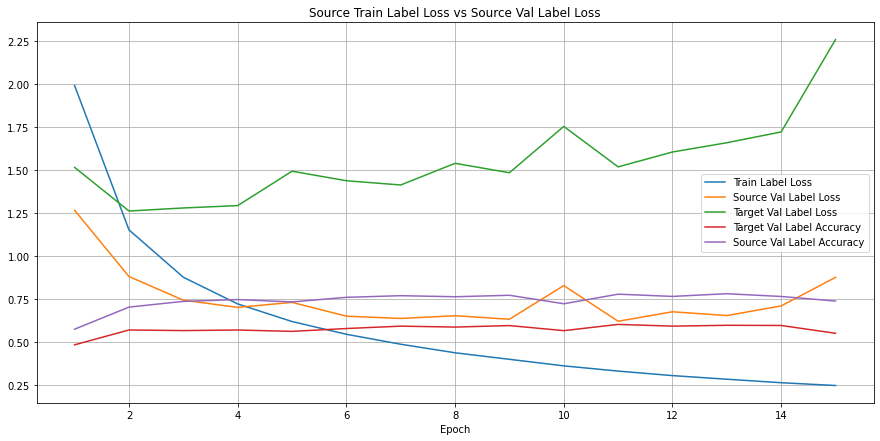

In [16]:
get_loss_curve(experiment)

<AxesSubplot:title={'center':'Results'}>

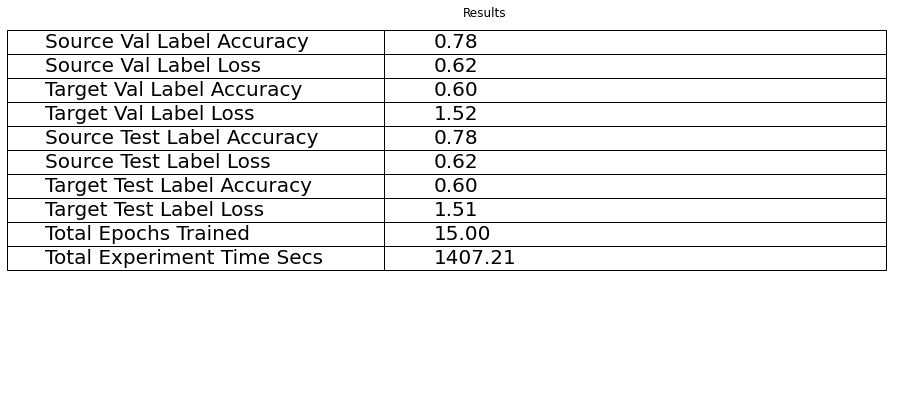

In [17]:
get_results_table(experiment)

<AxesSubplot:title={'center':'Per Domain Accuracy'}, xlabel='domain'>

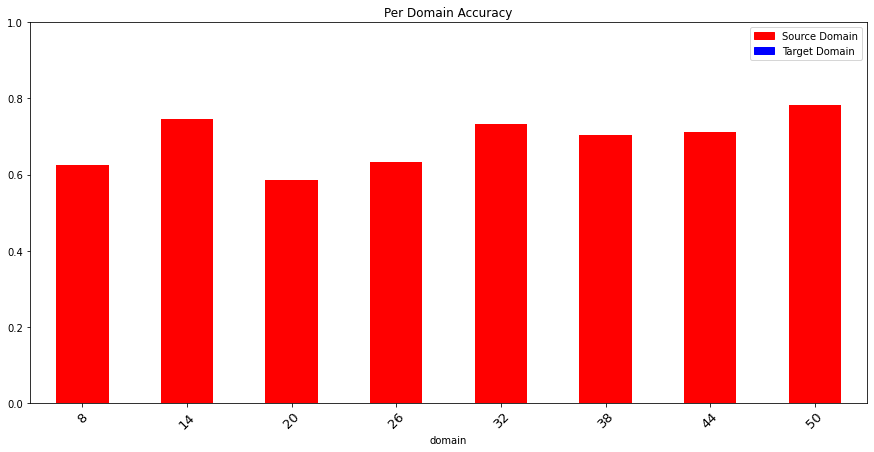

In [18]:
get_domain_accuracies(experiment)

In [19]:
print("Source Test Label Accuracy:", experiment["results"]["source_test_label_accuracy"], "Target Test Label Accuracy:", experiment["results"]["target_test_label_accuracy"])
print("Source Val Label Accuracy:", experiment["results"]["source_val_label_accuracy"], "Target Val Label Accuracy:", experiment["results"]["target_val_label_accuracy"])

Source Test Label Accuracy: 0.7793854166666667 Target Test Label Accuracy: 0.6007083333333333
Source Val Label Accuracy: 0.777796875 Target Val Label Accuracy: 0.602015625


In [20]:
json.dumps(experiment)

'{"experiment_name": "cnn_3:oracle.run1-oracle.run2", "parameters": {"experiment_name": "cnn_3:oracle.run1-oracle.run2", "domains_source": [8, 32, 50, 14, 20, 26, 38, 44], "domains_target": [8, 32, 50, 14, 20, 26, 38, 44], "labels": ["3123D52", "3123D65", "3123D79", "3123D80", "3123D54", "3123D70", "3123D7B", "3123D89", "3123D58", "3123D76", "3123D7D", "3123EFE", "3123D64", "3123D78", "3123D7E", "3124E4A"], "pickle_name_source": "oracle.Run1_10kExamples_stratified_ds.2022A.pkl", "pickle_name_target": "oracle.Run2_10kExamples_stratified_ds.2022A.pkl", "device": "cuda", "lr": 0.0001, "batch_size": 128, "normalize_source": false, "normalize_target": false, "num_examples_per_domain_per_label_source": -1, "num_examples_per_domain_per_label_target": -1, "torch_default_dtype": "torch.float32", "n_epoch": 50, "patience": 3, "criteria_for_best": "target_accuracy", "x_net": [{"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}}, {"class": "Conv2d", "kargs": {"in_channels": 1, "out_channels